# 1. Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?

In [1]:
import os
import numpy as np
from skimage import io, color
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

exFolPath = "/content/drive/MyDrive/360 Rocks"

imgFiles = [f for f in os.listdir(exFolPath) if f.endswith('.jpg')]

imgs = []
labels =[]
for file in imgFiles:
    imgPath = os.path.join(exFolPath, file)

    img = io.imread(imgPath)

    if img.shape[-1] == 3:
        img = color.rgb2gray(img)

    imgs.append(img)
    label = file[0]
    labels.append(label)

flattenedImgs = np.array([img.flatten() for img in imgs])

sclr = StandardScaler()

scaledImgs = sclr.fit_transform(flattenedImgs)

pca = PCA()

pca.fit(scaledImgs)

cumVariance = np.cumsum(pca.explained_variance_ratio_)

nComps_90 = np.argmax(cumVariance >= 0.90) + 1

print(f"Number of components needed to preserve 90% of variance: {nComps_90}")






Number of components needed to preserve 90% of variance: 153


No. of components needed to preserve 90% of variance = 153

# 2. Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA.

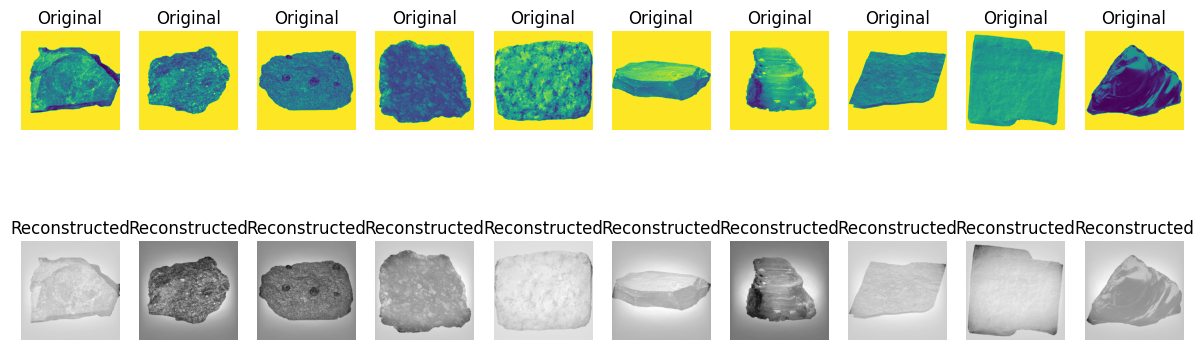

In [2]:
import os
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(imgs[i])
    plt.title('Original')
    plt.axis('off')

reconstructImgs = pca.inverse_transform(pca.transform(scaledImgs))

reconstructImgs = reconstructImgs.reshape(flattenedImgs.shape[0], *imgs[0].shape)

for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructImgs[i], cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()


# 3. Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the fname (I, M and S). We will now try to see if the visualization can help us identify different clusters.

# A. Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

In [3]:
pca = PCA(n_components=2)
pca.fit(scaledImgs)

varExplained = pca.explained_variance_ratio_
print("Variance explained by the first two principal components:", varExplained)

Variance explained by the first two principal components: [0.18305586 0.1254353 ]


Variance explained by the first two principal components: [0.18305586 0.1254353 ]

# B. Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynbLinks to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS.

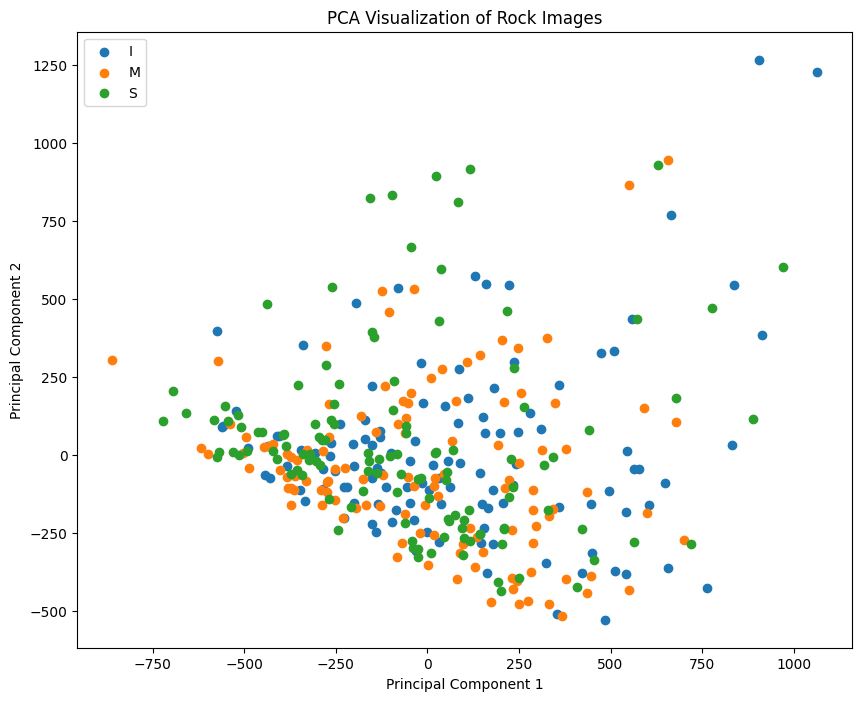

In [4]:
projectedImgs = pca.transform(scaledImgs)

plt.figure(figsize=(10, 8))
for cat in ['I', 'M', 'S']:
    indexes = [i for i, label in enumerate(labels) if label == cat]
    plt.scatter(projectedImgs[indexes, 0], projectedImgs[indexes, 1], label=cat)

plt.title('PCA Visualization of Rock Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


We can observe 3 clusters in the image.

<ipython-input-5-fb4ef7819a44>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


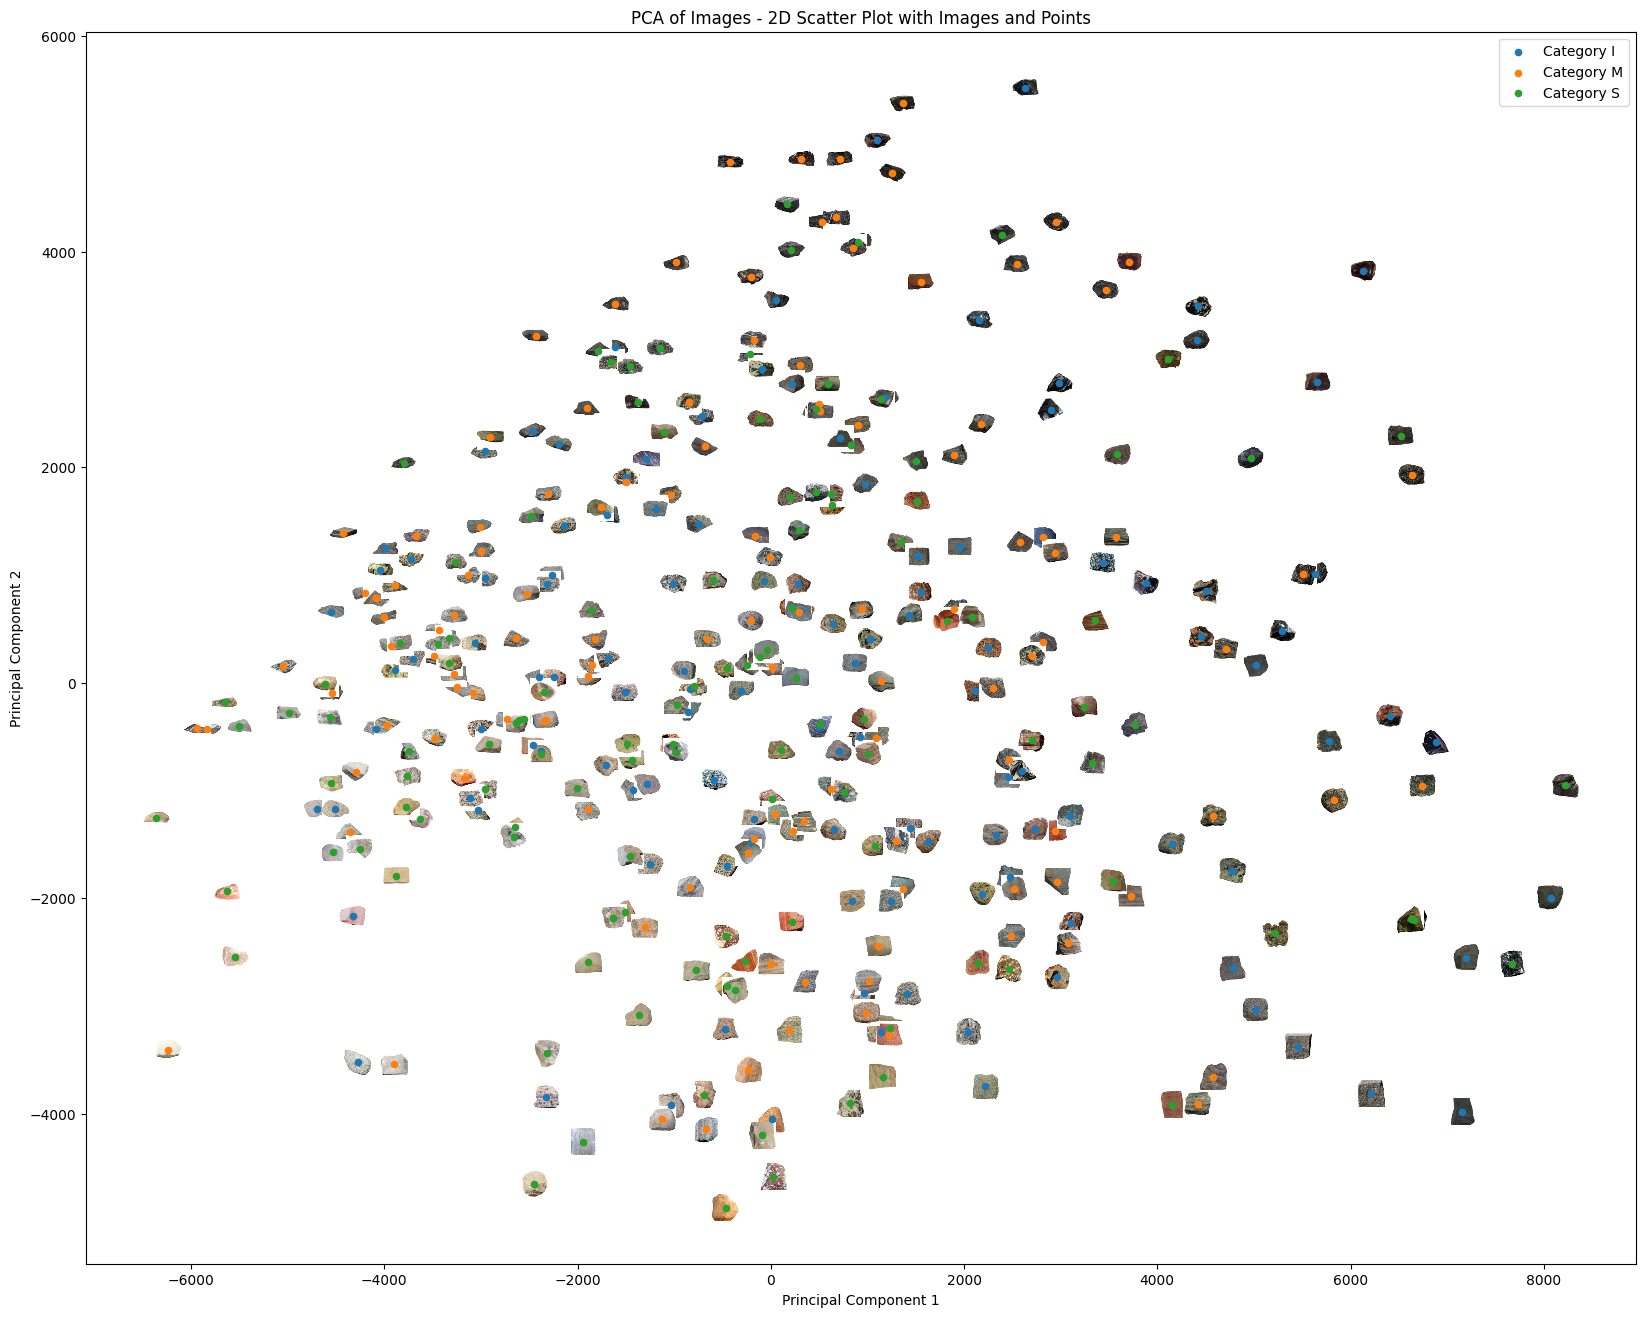

In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt

folPath = '/content/drive/MyDrive/360 Rocks'
imgsData = []
target_size = (64, 64)

for fname in os.listdir(folPath):
  img = Image.open(os.path.join(folPath, fname))
  if img is not None:
    img = img.resize(target_size, Image.ANTIALIAS)
    imgsData.append(np.array(img))

labelEncoder = LabelEncoder()
catsEncoded = labelEncoder.fit_transform(labels)

pca = PCA(n_components=2)
imgsPca = pca.fit_transform(np.array(imgsData).reshape(len(imgsData),-1))

fig, ax = plt.subplots(figsize=(20, 16))

for i, (x, y) in enumerate(imgsPca):
  imgBox = OffsetImage(imgsData[i], cmap='gray', zoom=0.3)
  ab = AnnotationBbox(imgBox, (x, y), frameon=False, xycoords='data',boxcoords="data", pad=0)
  ax.add_artist(ab)

for cat in np.unique(catsEncoded):
  indexes = (catsEncoded == cat)
  ax.scatter(imgsPca[indexes, 0], imgsPca[indexes, 1], label=f'Category {labelEncoder.inverse_transform([cat])[0]}', s=20, zorder=5)

ax.set_title('PCA of Images - 2D Scatter Plot with Images and Points')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


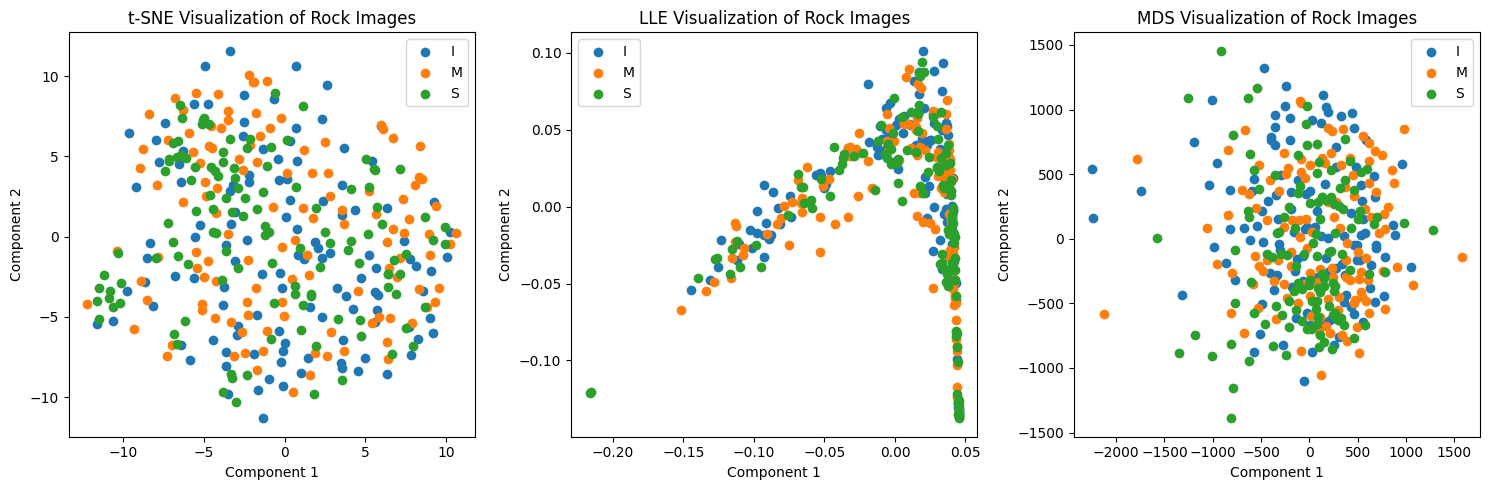

In [6]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
import matplotlib.pyplot as plt

dimensionReductionTechniques = {
    't-SNE': TSNE(n_components=2),
    'LLE': LocallyLinearEmbedding(n_components=2),
    'MDS': MDS(n_components=2)
}

plt.figure(figsize=(15, 5))
for i, (method, reducer) in enumerate(dimensionReductionTechniques.items(), start=1):
    projectedImgs = reducer.fit_transform(scaledImgs)

    plt.subplot(1, 3, i)
    for cat in ['I', 'M', 'S']:
        indexes = [j for j, label in enumerate(labels) if label == cat]
        plt.scatter(projectedImgs[indexes, 0], projectedImgs[indexes, 1], label=cat)
    plt.title(f'{method} Visualization of Rock Images')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()

plt.tight_layout()
plt.show()

# C. Discuss your observations.

**t-SNE:** The t-SNE plot shows some separation between the three rock categories, but the clusters are not as distinct as in the PCA plot. There are also some points that appear to be outliers.
**LLE:** The LLE plot shows the least separation between the rock categories. The clusters are largely overlapping.
**MDS:** The MDS plot shows some separation between the rock categories, but the clusters are not as distinct as in the PCA plot. The MDS plot also appears to have some outliers.

# 4. Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, t-SNE, LLE and MDS to reduce the dimensionality of the images to 8. Then, compare those image embeddings with the ones from humans that are in the mds_360.txt file. Use Procrustes analysis to do the comparison (here is one example of how to do that mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data). Here matrix_with_human_data and matrix_with_pca_embeddings_data should be 360 by 8. disparity will tell you the difference in the data. Report disparity for each of the four dimensionality reduction methods. Compute the correlation coefficient between each dimension of mtx1 and mtx2 for each of the four methods - display results in a table.

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.preprocessing import StandardScaler

featsPath = "/content/drive/MyDrive/mds_360.txt"
featsStandardized = np.loadtxt(featsPath)

pca = PCA(n_components=8)
pcaFeats = pca.fit_transform(scaledImgs)

tsne = TSNE(n_components=8,method='exact')
tsneFeats = tsne.fit_transform(scaledImgs)

lle = LocallyLinearEmbedding(n_components=8)
lleFeats = lle.fit_transform(scaledImgs)

mds = MDS(n_components=8)
mdsFeats = mds.fit_transform(scaledImgs)



/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


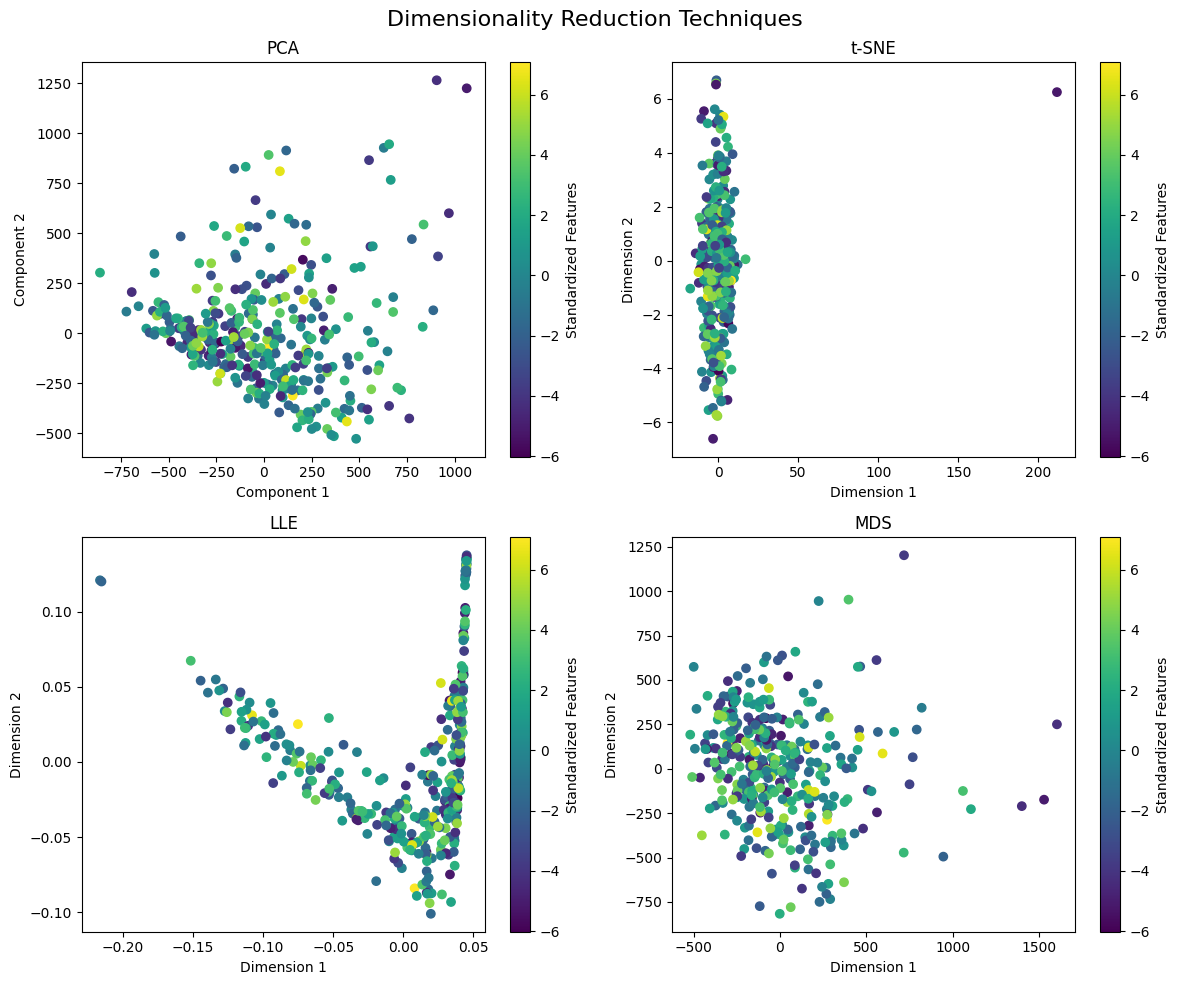

In [8]:
fig, axxes = plt.subplots(2, 2, figsize=(12, 10))

fig.suptitle('Dimensionality Reduction Techniques', fontsize=16)

scatterPca = axxes[0, 0].scatter(pcaFeats[:, 0], pcaFeats[:, 1], c=featsStandardized[:, 0], cmap='viridis')
axxes[0, 0].set_title('PCA')
axxes[0, 0].set_xlabel('Component 1')
axxes[0, 0].set_ylabel('Component 2')

scatterTsne = axxes[0, 1].scatter(tsneFeats[:, 0], tsneFeats[:, 1], c=featsStandardized[:, 0], cmap='viridis')
axxes[0, 1].set_title('t-SNE')
axxes[0, 1].set_xlabel('Dimension 1')
axxes[0, 1].set_ylabel('Dimension 2')

scatterLle = axxes[1, 0].scatter(lleFeats[:, 0], lleFeats[:, 1], c=featsStandardized[:, 0], cmap='viridis')
axxes[1, 0].set_title('LLE')
axxes[1, 0].set_xlabel('Dimension 1')
axxes[1, 0].set_ylabel('Dimension 2')

scatterMds = axxes[1, 1].scatter(mdsFeats[:, 0], mdsFeats[:, 1], c=featsStandardized[:, 0], cmap='viridis')
axxes[1, 1].set_title('MDS')
axxes[1, 1].set_xlabel('Dimension 1')
axxes[1, 1].set_ylabel('Dimension 2')

cbarPca = fig.colorbar(scatterPca, ax=axxes[0, 0], label='Standardized Features')
cbarTsne = fig.colorbar(scatterTsne, ax=axxes[0, 1], label='Standardized Features')
cbarLle = fig.colorbar(scatterLle, ax=axxes[1, 0], label='Standardized Features')
cbarMds = fig.colorbar(scatterMds, ax=axxes[1, 1], label='Standardized Features')

plt.tight_layout()

plt.show()


In [9]:
from scipy.spatial import procrustes
from scipy.stats import pearsonr

mtx1Pca, mtx2Pca, disparityPca = procrustes(featsStandardized, pcaFeats)
corrPca = [pearsonr(mtx1Pca[:, i], mtx2Pca[:, i])[0] for i in range(8)]

mtx1Tsne, mtx2Tsne, disparityTsne = procrustes(featsStandardized, tsneFeats)
corrTsne = [pearsonr(mtx1Tsne[:, i], mtx2Tsne[:, i])[0] for i in range(8)]

mtx1Lle, mtx2Lle, disparityLle = procrustes(featsStandardized, lleFeats)
corrLle = [pearsonr(mtx1Lle[:, i], mtx2Lle[:, i])[0] for i in range(8)]

mtx1Mds, mtx2Mds, disparityMds = procrustes(featsStandardized, mdsFeats)
corrMds = [pearsonr(mtx1Mds[:, i], mtx2Mds[:, i])[0] for i in range(8)]

print("Results of Procrustes Analysis and Correlation Coefficients:")
print("Method\t\tDisparity\tCorrelation Coefficients")
print("-------------------------------------------------------")
print(f"PCA\t\t{disparityPca:.4f}\t\t{corrPca}")
print(f"t-SNE\t\t{disparityTsne:.4f}\t\t{corrTsne}")
print(f"LLE\t\t{disparityLle:.4f}\t\t{corrLle}")
print(f"MDS\t\t{disparityMds:.4f}\t\t{corrMds}")


Results of Procrustes Analysis and Correlation Coefficients:
Method		Disparity	Correlation Coefficients
-------------------------------------------------------
PCA		0.9856		[0.12656186791174803, 0.11128907733615555, 0.10921848924338189, 0.12877676701131874, 0.1461431627452017, 0.14554369366172012, 0.09443575008295853, 0.1168351195014227]
t-SNE		0.9893		[0.10245828990713832, 0.08969538813572751, 0.0684669341505454, 0.17414110483740258, 0.1409969607817674, 0.09033535507984666, 0.116592868616412, 0.0973628496986334]
LLE		0.9777		[0.09916265554258906, 0.1571025465323093, 0.13829094678066037, 0.12912214488824034, 0.17632240782867264, 0.2119525162633458, 0.1285351570061724, 0.168304654219429]
MDS		0.9839		[0.1321387701121707, 0.1483786664311575, 0.1334752669728637, 0.12502903456737596, 0.13157967953643038, 0.16402477687423714, 0.05551090629729778, 0.15630362504980477]


# 5. Cluster the 360 images using K-Means.
# A. You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.
We would be using the ineria method and plot the graph between inertia and no. of clusters to determine the optimal no. of clusters.
# B. Set the number of clusters to 3 and report clustering accuracy.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

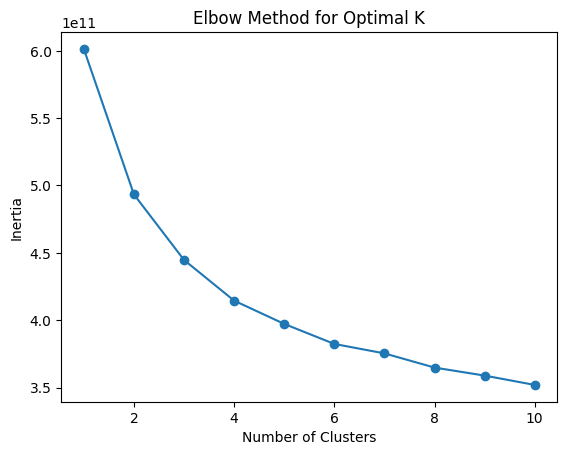

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


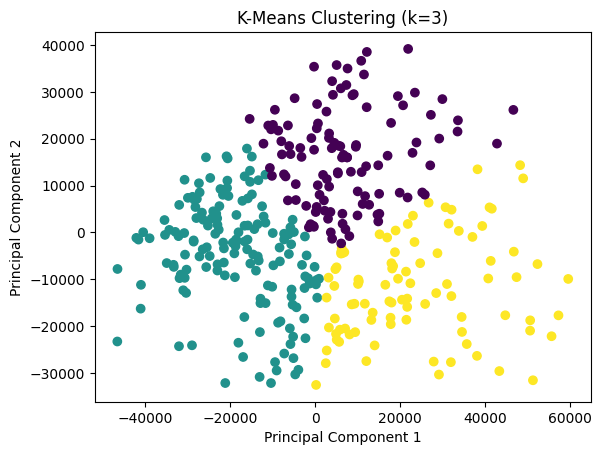

In [10]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

folPath = '/content/drive/MyDrive/360 Rocks'
imgFiles = [f for f in os.listdir(folPath) if f.endswith('.jpg') or f.endswith('.png')]

imgs = [cv2.imread(os.path.join(folPath, f), cv2.IMREAD_GRAYSCALE) for f in imgFiles]

flattenedImgs = [img.flatten() for img in imgs]

X = np.vstack(flattenedImgs)

pca = PCA(70)
XPca = pca.fit_transform(X)

inertia = []
for nClusts in range(1, 11):
    kMeans = KMeans(n_clusters=nClusts, random_state=42)
    kMeans.fit(XPca)
    inertia.append(kMeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

optimalNClusts = 3
kMeansFinal = KMeans(n_clusters=optimalNClusts, random_state=42)
labels = kMeansFinal.fit_predict(XPca)

plt.scatter(XPca[:, 0], XPca[:, 1], c=labels, cmap='viridis')
plt.title(f'K-Means Clustering (k={optimalNClusts})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We can look into the graph and determine the optimal no. of clusters to be equal to 4 from the elbow method.

In [11]:
truLabels = [f[0] for f in imgFiles]

clustToTruLabel = {0: 'I', 1: 'M', 2: 'S'}

predictedTruLabel = [clustToTruLabel[label] for label in labels]

acc = sum(1 for predict, true in zip(predictedTruLabel, truLabels) if predict == true) / len(truLabels)

print(f'Clustering Accuracy: {acc * 100:.2f}%')


Clustering Accuracy: 30.56%


# 6. Cluster the 360 images using EM.
# A. You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class.
We would be using AIC and BIC to determine optimal no. of clusters.

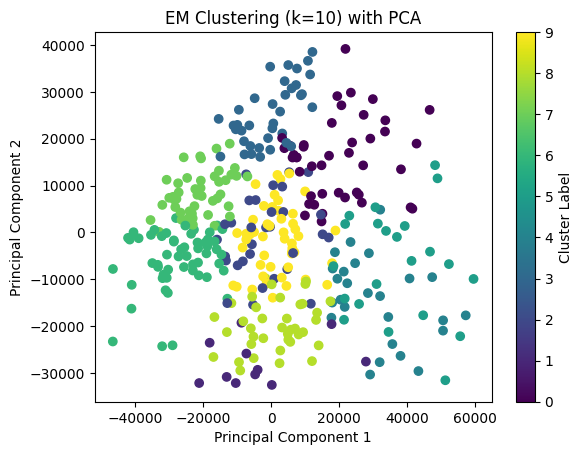

Optimal number of clusters (BIC): 10
Optimal number of clusters (AIC): 10


In [12]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(90)
XPca = pca.fit_transform(X)

bicVals = []
aicVals = []
for nComps in range(1, 11):
    gm = GaussianMixture(n_components=nComps, random_state=42)
    gm.fit(XPca)
    bicVals.append(gm.bic(XPca))
    aicVals.append(gm.aic(XPca))

optimalNCompsBic = np.argmin(bicVals) + 1
optimalNCompsAic = np.argmin(aicVals) + 1

optimalNComps = optimalNCompsBic
gm = GaussianMixture(n_components=optimalNComps, random_state=42)
cluster_labels = gm.fit_predict(XPca)

plt.scatter(XPca[:, 0], XPca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'EM Clustering (k={optimalNComps}) with PCA')
plt.colorbar(label='Cluster Label')
plt.show()

print(f'Optimal number of clusters (BIC): {optimalNCompsBic}')
print(f'Optimal number of clusters (AIC): {optimalNCompsAic}')


# B. Set the number of clusters to 3 and report clustering accuracy.

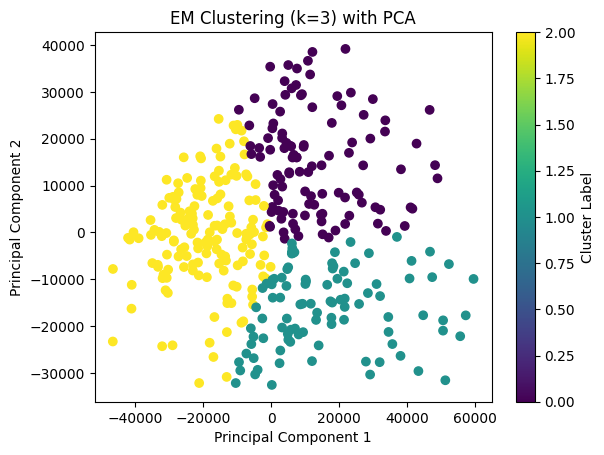

In [13]:
gm = GaussianMixture(n_components=3, random_state=42)
ClustLabels = gm.fit_predict(XPca)

plt.scatter(XPca[:, 0], XPca[:, 1], c=ClustLabels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'EM Clustering (k={3}) with PCA')
plt.colorbar(label='Cluster Label')
plt.show()


In [14]:
truLabels = [f[0] for f in imgFiles]

predictedTruLabel = ['I' if label == 0 else 'M' if label == 1 else 'S' for label in ClustLabels]

acc = sum(1 for predict, true in zip(predictedTruLabel, truLabels) if predict == true) / len(truLabels)

print(f'Clustering Accuracy: {acc * 100:.2f}%')


Clustering Accuracy: 35.00%


# C. Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).

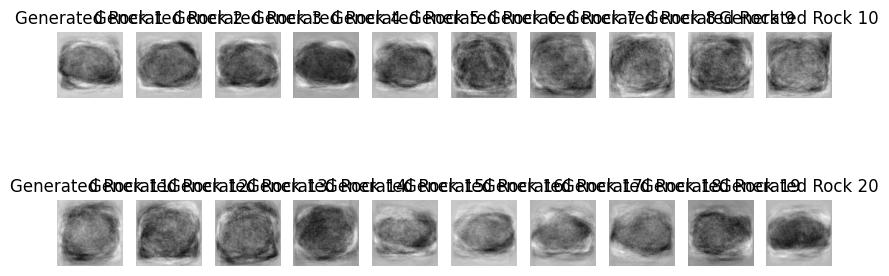

In [15]:
import matplotlib.pyplot as plt
import numpy as np

newDataPca = gm.sample(n_samples=20)[0]

newImgs = pca.inverse_transform(newDataPca)

newImgs = newImgs.reshape(-1, *imgs[0].shape)

plt.figure(figsize=(10, 4))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(newImgs[i], cmap='gray')
    plt.title(f'Generated Rock {i+1}')
    plt.axis('off')

plt.show()


# 7. Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the fname (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training. We recommend using Colab (the free version should be totally fine), but make sure to run it with a GPU to speed up the training - to add a GPU on Colab go to Edit->Notebook settings).

# A. Report the training time (use code to do this).
# B. Plot training and validation loss and accuracy as a function of training epochs.

Epoch 1/15
12/12 [==============================] - 10s 165ms/step - loss: 35.1377 - accuracy: 0.3333 - val_loss: 1.1137 - val_accuracy: 0.3000
Epoch 2/15
12/12 [==============================] - 0s 35ms/step - loss: 1.1642 - accuracy: 0.3278 - val_loss: 1.0940 - val_accuracy: 0.3250
Epoch 3/15
12/12 [==============================] - 0s 30ms/step - loss: 1.0929 - accuracy: 0.3778 - val_loss: 1.0971 - val_accuracy: 0.3833
Epoch 4/15
12/12 [==============================] - 0s 33ms/step - loss: 1.0975 - accuracy: 0.3528 - val_loss: 1.0969 - val_accuracy: 0.4333
Epoch 5/15
12/12 [==============================] - 0s 30ms/step - loss: 1.1034 - accuracy: 0.3806 - val_loss: 1.0927 - val_accuracy: 0.3417
Epoch 6/15
12/12 [==============================] - 0s 30ms/step - loss: 1.1002 - accuracy: 0.3889 - val_loss: 1.0992 - val_accuracy: 0.3500
Epoch 7/15
12/12 [==============================] - 0s 31ms/step - loss: 1.1080 - accuracy: 0.3917 - val_loss: 1.0909 - val_accuracy: 0.3917
Epoch 8/15

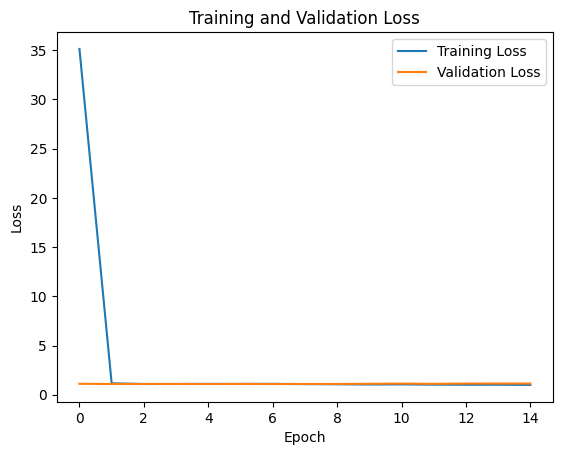

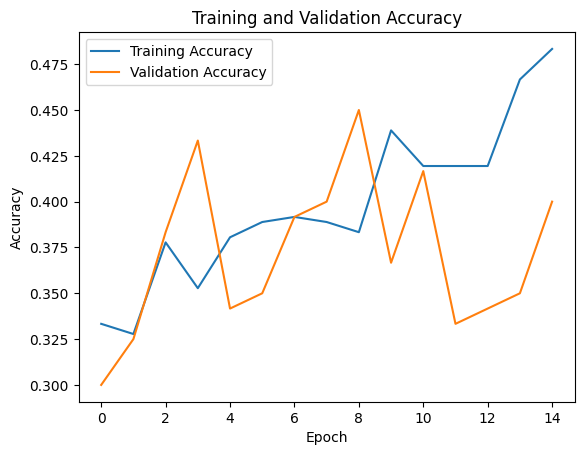

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [16]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from scipy.spatial import procrustes
from scipy.stats import pearsonr
import time

IMG_WDTH = 150
IMG_HGHT = 150
N_CLASSES = 3
BTCH_SIZE = 32
N_EPOCHS = 15
LRN_RATE = 0.001

trainDataDir = '/content/drive/MyDrive/360 Rocks'
valiDataDir = '/content/drive/MyDrive/120 Rocks'
humanDataDir360 = '/content/drive/MyDrive/mds_360.txt'
humanDataDir120 = '/content/drive/MyDrive/mds_120.txt'

def loadImgsFromFolder(folder):
    imgs = []
    labels = []
    for fname in os.listdir(folder):
        if fname.endswith('.jpg') or fname.endswith('.png'):
            imgPath = os.path.join(folder, fname)
            img = load_img(imgPath, target_size=(IMG_WDTH, IMG_HGHT))
            imgArray = img_to_array(img)
            imgs.append(imgArray)
            labels.append(fname[0])
    return np.array(imgs), np.array(labels)

XTrain, yTrain = loadImgsFromFolder(trainDataDir)
XVali, yVali = loadImgsFromFolder(valiDataDir)

labelDict = {'I': 0, 'M': 1, 'S': 2}
yTrainEncoded = to_categorical([labelDict[label] for label in yTrain], num_classes=N_CLASSES)
yValiEncoded = to_categorical([labelDict[label] for label in yVali], num_classes=N_CLASSES)

mdl = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WDTH, IMG_HGHT, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.7),
    layers.Dense(256, activation='relu'),
    layers.Dense(N_CLASSES, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=LRN_RATE)
mdl.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

startTime = time.time()
history = mdl.fit(XTrain, yTrainEncoded, batch_size=BTCH_SIZE, epochs=N_EPOCHS, validation_data=(XVali, yValiEncoded))
endTime = time.time()
trainTime = endTime - startTime
print("Training Time: {:.2f} seconds".format(trainTime))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

mdl.summary()



# C. How many parameters does the network have? How many of those parameters are bias parameters?

In [17]:
import numpy as np

totalParams = mdl.count_params()

totalBiasParams = sum([np.count_nonzero(layer.get_weights()[1]) if len(layer.get_weights()) > 1 else 0 for layer in mdl.layers])

print("Total number of parameters:", totalParams)
print("Total number of bias parameters:", totalBiasParams)



Total number of parameters: 6943555
Total number of bias parameters: 1250


Total number of parameters: 6943555
Total number of bias parameters: 1251


D. Compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table. [3 points]


In [18]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from scipy.stats import pearsonr
from scipy.spatial import procrustes
from keras import backend as K

with open('/content/drive/MyDrive/mds_360.txt') as f:
    humanData360 = np.loadtxt(f)

with open('/content/drive/MyDrive/mds_120.txt') as f:
    humanData120 = np.loadtxt(f)

layerIndex = -2
getLayerOutput = K.function([mdl.layers[0].input], [mdl.layers[layerIndex].output])

trainActivations = getLayerOutput([XTrain])[0]

valActivations = getLayerOutput([XVali])[0]

trainActivationsFlat = trainActivations.reshape(len(trainActivations), -1)

pca = PCA(n_components=8)
trainActivationsPca = pca.fit_transform(trainActivationsFlat)
valActivationsFlat = valActivations.reshape(len(valActivations), -1)

valActivationsPca = pca.transform(valActivationsFlat)

mds = MDS(n_components=8, random_state=42)
humanData360Mds = mds.fit_transform(humanData360)
humanData120Mds = mds.fit_transform(humanData120)

print("Shape of trainActivationsPca:", trainActivationsPca.shape)
print("Shape of humanData360Mds:", humanData360Mds.shape)

if trainActivationsPca.shape[0] != humanData360Mds.shape[0]:
    humanData360Mds = humanData360Mds[:trainActivationsPca.shape[0], :]

disparityTrain, _, trainCorrs = procrustes(trainActivationsPca, humanData360Mds)
disparityVali, _, valiCorrs = procrustes(valActivationsPca, humanData120Mds)

print("Training Data:")
print("Disparity:", disparityTrain)
print("Correlation Coefficients:")
print(trainCorrs)

print("\nValidation Data:")
print("Disparity:", disparityVali)
print("Correlation Coefficients:")
print(valiCorrs)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Shape of trainActivationsPca: (360, 8)
Shape of humanData360Mds: (360, 8)
Training Data:
Disparity: [[-4.71869463e-03  1.98962859e-03 -1.16458663e-02 ...  8.60199843e-03
   8.95232185e-05 -6.55431401e-03]
 [ 4.47730157e-03 -2.27412304e-02  1.30209972e-02 ... -4.67624701e-04
   2.92036638e-03 -1.20151666e-03]
 [-2.05573314e-02  2.92496818e-04  2.21103834e-03 ...  9.66860106e-04
   1.90006273e-03  1.89453053e-04]
 ...
 [-1.26920801e-02 -2.58799651e-03 -3.94272673e-03 ...  8.21595059e-04
  -4.77181576e-04 -2.12847075e-03]
 [-1.92424948e-02  1.95954764e-03  4.50112835e-03 ... -1.12205601e-03
  -3.59504898e-04  2.54303058e-03]
 [-2.48054350e-02  4.73855608e-03  1.51935983e-03 ...  2.25805422e-04
   7.39181514e-04  2.64002501e-04]]
Correlation Coefficients:
0.9797669556293945

Validation Data:
Disparity: [[-3.39168664e-02  7.24354264e-03  1.07730637e-02 -3.68027058e-03
  -2.19584705e-03  5.08798418e-03  3.69216911e-03 -1.40753783e-03]
 [ 1.63854805e-01  5.96261022e-02  3.16958745e-02  1.5263

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Team Members:
1. Varsha Karanam
2. Pradyumna Reddy Kaputhimmareddy
3. Veda Charitha Bellam

# References:
1. ChatGPT
2. https://osf.io/d6b9y/
3. www.kaggle.com
4. https://machinelearningmastery.com/probabilistic-model-selection-measures/
